In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Identifying the order of a moving average process

In [2]:
df = pd.read_csv('../data/widget_sales.csv')
df

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108
...,...
495,64.087371
496,63.992081
497,63.029894
498,61.671797


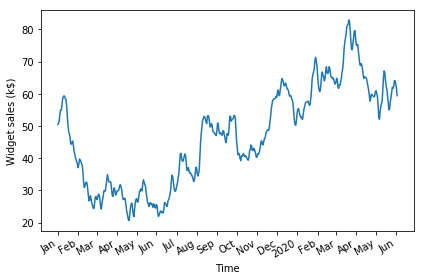

In [3]:
fig, ax = plt.subplots()
ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')
plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
)
fig.autofmt_xdate()
plt.tight_layout()

### Test for stationarity

In [4]:
ADF_result = adfuller(df['widget_sales'])
print('ADF Statistics: {}'.format(ADF_result[0]))
print('p-value: {}'.format(ADF_result[1]))

ADF Statistics: -1.5121662069358965
p-value: 0.5274845352272646


p-value is greater than 0.05. Therefore, our time series is **not stationary**

In [5]:
widget_sales_diff = np.diff(df['widget_sales'], n=1)

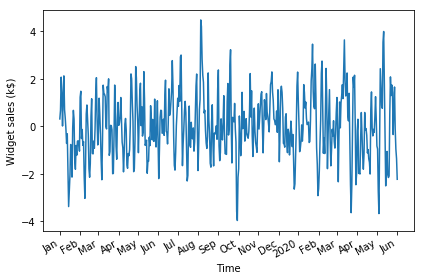

In [6]:
fig, ax = plt.subplots()
ax.plot(widget_sales_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')
plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
)
fig.autofmt_xdate()
plt.tight_layout()

In [7]:
ADF_result = adfuller(widget_sales_diff)
print('ADF Statistics: {}'.format(ADF_result[0]))
print('p-value: {}'.format(ADF_result[1]))

ADF Statistics: -10.57665778034195
p-value: 7.076922818587652e-19


Therefore, with a large negative ADF statistic and a p-value much smaller than 0.05, we can say that our series **is stationary**

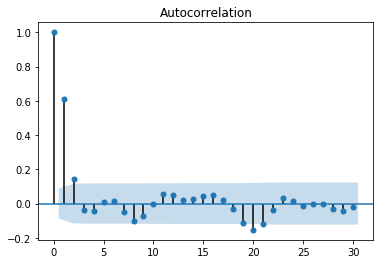

In [8]:
plot_acf(widget_sales_diff, lags=30);

There are significant coefficients up until lag 2. This means that we have a stationary moving average process of order 2

## Forecasting a moving average process

In [9]:
df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})
train = df_diff[:int(0.9 * len(df_diff))]
test = df_diff[int(0.9 * len(df_diff)):]
print(len(train), len(test))

449 50


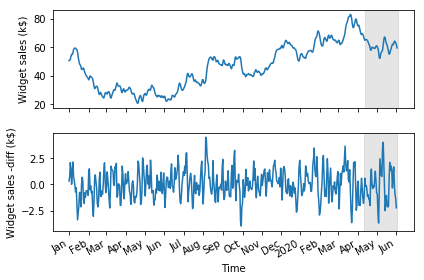

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(df_diff['widget_sales_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales -diff (k$)')
ax2.axvspan(449, 499, color='#808080', alpha=0.2)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
)
fig.autofmt_xdate()
plt.tight_layout()

In [11]:
def rolling_forecast(
    df: pd.DataFrame,
    train_len: int,
    horizon: int,
    window:int,
    method:str
) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0, 0, 2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        return pred_MA

In [12]:
pred_df = test.copy()
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA
pred_df

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994
454,-1.118891,0.032183,-0.096564,0.115810
455,-0.979693,0.028764,-1.118891,-0.795666
456,-1.369431,0.028764,-1.118891,-0.191286
457,-1.517477,0.023498,-1.369431,-0.922824
458,-2.006735,0.023498,-1.369431,-0.254060


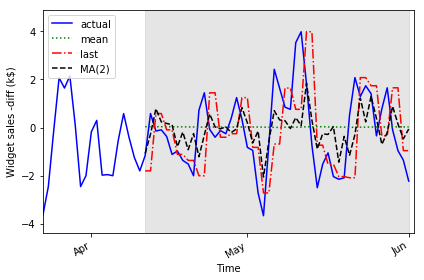

In [13]:
fig, ax = plt.subplots()

ax.plot(df_diff['widget_sales_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales -diff (k$)')
ax.axvspan(449, 498, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
)
plt.xlim(430, 499)
fig.autofmt_xdate()
plt.tight_layout()

In [14]:
mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

2.5606299456880555 3.2494260812249225 1.9481714497792944


In [15]:
df['pred_widget_sales'] = pd.Series()
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()
df

/home/msdc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


,widget_sales,pred_widget_sales
0,50.496714,NaN
1,50.805493,NaN
2,51.477758,NaN
3,53.542228,NaN
4,54.873108,NaN
...,...,...
495,64.087371,60.335201
496,63.992081,61.218392
497,63.029894,61.365771
498,61.671797,60.895973


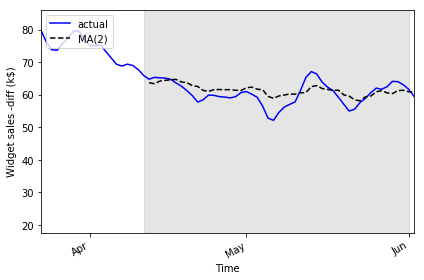

In [16]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales -diff (k$)')
ax.axvspan(449, 498, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
)
plt.xlim(430, 499)
fig.autofmt_xdate()
plt.tight_layout()

In [17]:
mae_MA_undiff = mean_absolute_error(
    df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:]
)
mae_MA_undiff

2.3244709244827213